### Setup the Environment

In [1]:
import numpy as np
import epios
import epipi
from scipy.interpolate import interp1d, make_interp_spline
import matplotlib.pyplot as plt
import pandas as pd
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import stan
import arviz as az
import nest_asyncio
import plotly.graph_objs as go
nest_asyncio.apply()

demo_data = pd.read_csv('../EpiOS/demographics_sec.csv')
time_data = pd.read_csv('../EpiOS/inf_status_history_sec.csv')
true_rt_df = pd.read_csv('../EpiOS/secondary_infections.csv')
true_rt = true_rt_df['R_t'].values
omega = pd.read_csv('./PCR_curve_summary.csv')['median'].values
omega_pos_list = np.arange(1, 31) * 10
omega = omega[omega_pos_list]
sampling_seed = 40
postprocess = epios.PostProcess(time_data=time_data, demo_data=demo_data)

### Aim 1: Use interpolation and `branchpro` to predict $R_t$ by using samples from `EpiOS`

By using EpiOS, can directly generate samples using imperfect testing or perfect testing. Here we will start with the perfect testing, i.e. no false +ve / -ve / non-responders.

#### Perfect Testing:

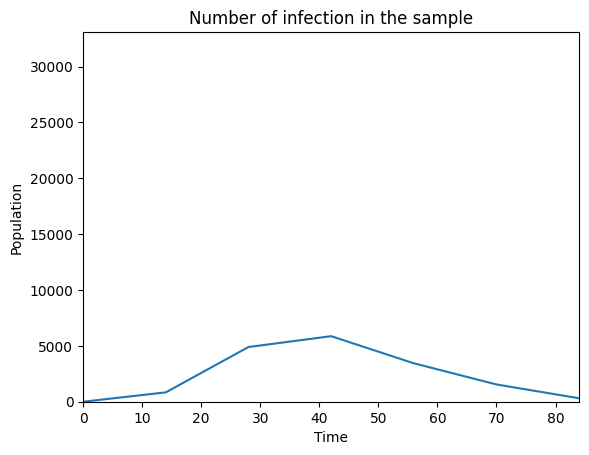

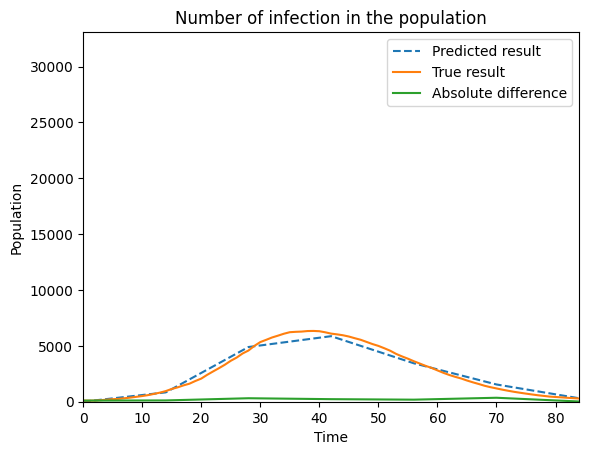

In [42]:
# Generate samples using EpiOS

# Define the class instance
time_sample=[0, 14, 28, 42, 56, 70, 84]

# Do prediction and comparison based age-region stratification
result, diff = postprocess.predict.Base(sample_size=750,
                                        time_sample=time_sample,
                                        comparison=True,
                                        #  non_responder=False,
                                        gen_plot=True,
                                        sample_strategy='Random',
                                        seed=sampling_seed)

true_result_plot = []
for t in range(max(time_sample) + 1):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result_plot.append(num)

/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.



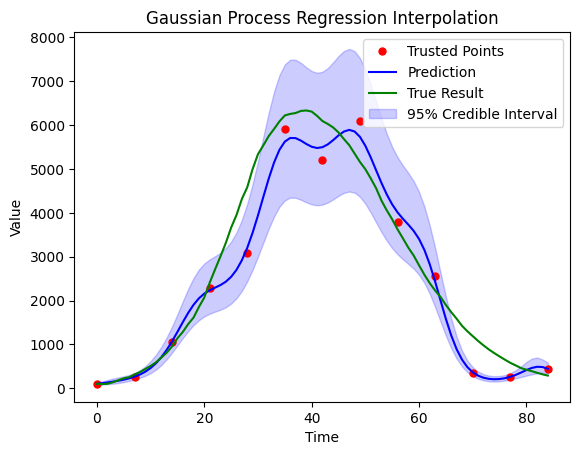

In [59]:
# Gaussian Process Interpolation
# Trusted data points
result[1][0] = 100 / len(demo_data)
X = np.array(time_sample).reshape(-1, 1)  # Time points
y = np.array(result[1]) * len(demo_data)  # Values
y = np.log(y)  # Logarithm of the values

# Define Gaussian Process
kernel = ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-6, 1e6)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-3, 1e-2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
X_all = np.arange(max(time_sample) + 1).reshape(-1, 1)
y_pred, sigma = gp.predict(X_all, return_std=True)
ci_lower = y_pred - 1.96 * sigma
ci_higher = y_pred + 1.96 * sigma
y_pred = np.exp(y_pred)  # Exponential of the prediction
ci_lower = np.exp(ci_lower)  # Exponential of the lower bound
ci_higher = np.exp(ci_higher)  # Exponential of the higher bound

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.plot(X.ravel(), np.exp(y), 'r.', markersize=10, label='Trusted Points')
plt.plot(X_all.ravel(), y_pred, 'b-', label='Prediction')
plt.plot(true_result_plot, 'g-', label='True Result')
plt.fill_between(X_all.ravel(), ci_lower, ci_higher,
                 alpha=0.2, color='blue', label='95% Credible Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Gaussian Process Regression Interpolation')
plt.legend()
plt.show()

y_interpolated = y_pred

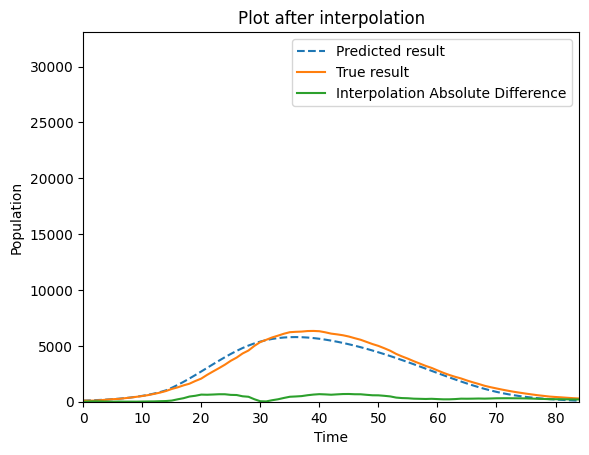

B-Spline Absolute Difference is 27595.43530106
B-Spline Absolute Max is 691.9647442475898


In [19]:
# Use B-Spline interpolation
k = 3 # Degree of the spline
spline = make_interp_spline(time_sample, np.array(result[1]) * len(demo_data), k=k, bc_type='natural')  # Natural boundary conditions
y_interpolated = spline(range(max(time_sample) + 1))
x1 = time_sample[0]
x2 = time_sample[1]
y1 = true_result_plot[0]
y2 = result[1][1] * len(demo_data)
c = (np.log(y2) - np.log(y1)) / (x2 - x1)
A = y1 * np.exp(c * x1)
def exp_interpolation(x, A, c):
    return A * np.exp(c * x)
y_interpolated[0:time_sample[1]] = exp_interpolation(range(time_sample[1]), A, c)
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_bspline_14days = np.sum(diff_interp)
max_bspline_14days = max(diff_interp)
print('B-Spline Absolute Difference is', score_bspline_14days)
print('B-Spline Absolute Max is', max_bspline_14days)

Remarks for this interpolation result:

1. In this B-Spline implementation, I manually modify the very first interpolation interval into exponential interpolation (calculate a exponential function that passes through the first two points). The reason is to avoid negative values at the very beginning of interpolation. Furthermore, the growth is almost exponential at the beginning of this epidimeological growth.

2. More adjustments like the first point should be made in order to make this interpolation much more reasonable. `This could be the future work.`

Based on this interpolation result, we want to predict the $R_t$ values. However, using `branchpro` to predict $R_t$ requires the incidences on each day rather than prevalence (total number of infection). Therefore, we develop a package named `EpiPI` to predict the incidecnes. Running the `EpiPI` part firstly will help you to define the variables in the following block. Assume we get the predicted incidecnes, we can use `branchpro` to estimate the $R_t$ given a serial interval. 

In [50]:
# Use incidence data to predict R_t value

# Define variables needed for calculating R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 3.96
ws_var = 4.75**2
theta_num = ws_var / ws_mean
k = ws_mean / theta_num
w_dist = scipy.stats.gamma(k, scale=theta_num)
disc_w = w_dist.pdf(range(len(theta)))
serial_interval = disc_w
serial_interval = serial_interval[1:]

# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': pre_I
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
# inc_data_true = pd.DataFrame(
#     {
#         'Time': np.arange(len(theta)),
#         'Incidence Number': incidences_true[:len(theta)]
#     }
# )

# inference_true = branchpro.BranchProPosterior(
#     inc_data=inc_data_true,
#     daily_serial_interval=serial_interval,
#     alpha=a,
#     beta=1/b)

# inference_true.run_inference(tau=tau)
# intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

# fig.add_interval_true_rt(intervals_true)  # Here I used a modified version of branchpro method to plot the true R_t
fig.add_interval_rt(intervals)
true_rt_plot = go.Scatter(
    y=true_rt[starting_time_point:end_time_point],
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual R_t',
    line_color='green'
)

fig.add_trace(true_rt_plot)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

Remark for this $R_t$ plot:

1. The prior distribution are not properly set, since I have not read paper about how to set these values for COVID. Here I just put some random numbers here to see the performance of predicting $R_t$. `This is necessary to be completed.`

#### Imperfect Testing:

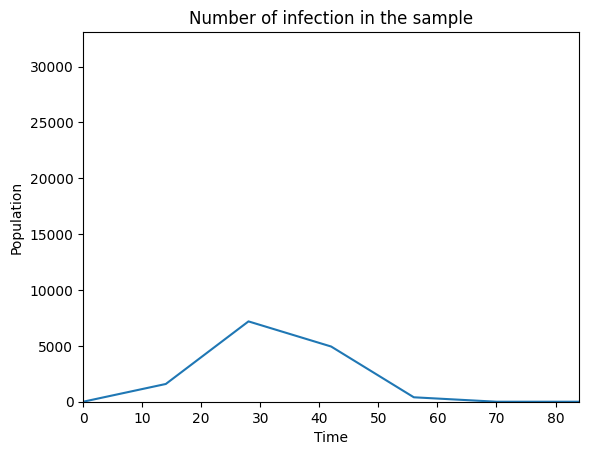

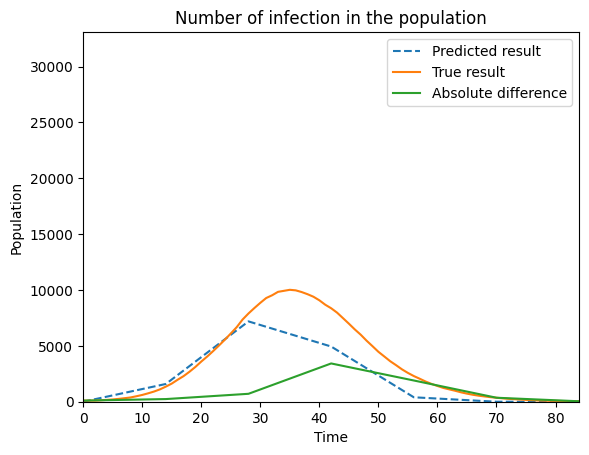

In [7]:
# Generate samples using EpiOS

# Define the class instance
practical = epios.PracticalSampler(time_data=time_data, demo_data=demo_data, positivity_curve=omega)
time_sample=[0, 14, 28, 42, 56, 70, 84]

# Do prediction and comparison based age-region stratification
result, diff = practical.predict_base(sample_size=750,
                                      time_sample=time_sample,
                                      comparison=True,
                                      #  non_responder=False,
                                      gen_plot=True,
                                      sample_strategy='Random',
                                      seed=10)

In [ ]:
# Use B-Spline interpolation
true_result_plot = []
for t in range(max(time_sample) + 1):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result_plot.append(num)
k = 3 # Degree of the spline
spline = make_interp_spline(time_sample, np.array(result[1]) * len(demo_data), k=k, bc_type='natural')  # Natural boundary conditions
y_interpolated = spline(range(max(time_sample) + 1))
x1 = time_sample[0]
x2 = time_sample[1]
y1 = true_result_plot[0]
y2 = result[1][1] * len(demo_data)
c = (np.log(y2) - np.log(y1)) / (x2 - x1)
A = y1 * np.exp(c * x1)
def exp_interpolation(x, A, c):
    return A * np.exp(c * x)
y_interpolated[0:time_sample[1]] = exp_interpolation(range(time_sample[1]), A, c)
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_bspline_14days = np.sum(diff_interp)
max_bspline_14days = max(diff_interp)
print('B-Spline Absolute Difference is', score_bspline_14days)
print('B-Spline Absolute Max is', max_bspline_14days)

In [ ]:
# Use incidence data to predict R_t value

# Define variables needed for calculating R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 4
ws_var = 3**2
theta_num = ws_var / ws_mean
k = ws_mean / theta_num
w_dist = scipy.stats.gamma(k, scale=theta_num)
disc_w = w_dist.pdf(range(len(theta)))
serial_interval = disc_w

# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': pre_I
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
inc_data_true = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': incidences_true[:len(theta)]
    }
)

inference_true = branchpro.BranchProPosterior(
    inc_data=inc_data_true,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference_true.run_inference(tau=tau)
intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

fig.add_interval_true_rt(intervals_true)  # Here I used a modified version of branchpro method to plot the true R_t
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

### Aim 2: Develop a computational tools for predicting incidences based on prevalence, which is this package - `EpiPI`

Definitions:

0. `Infected`$\coloneqq$ People that are Exposed or Infected in EpiABM. Reason: There is an incubation period for COVID.
1. $\theta_t\coloneqq$ The number of infected people at time $t$ (`Prevalence`)
2. $\omega_t\coloneqq$ The probability of a PCR positive test at $t$ days after the infection
3. $I_t\coloneqq$ The number of people that become infected at time $t$ (`Incidences`)

In [44]:
# Prepare necessary data
theta_inter = y_interpolated
theta_true = true_result_plot

In [ ]:
# Optional: Can define customised prior for the parameters
# Just need to add one more parameter `prior` when defining the IncidenceController class
prior = []
for i in range(len(theta)):
    prior.append(epipi.NormalPrior(1000, 200))
prior.append(epipi.NormalPrior(0, 1))

In order to compare the the performance of incidences prediction, firstly calculate the actual incidences each day.

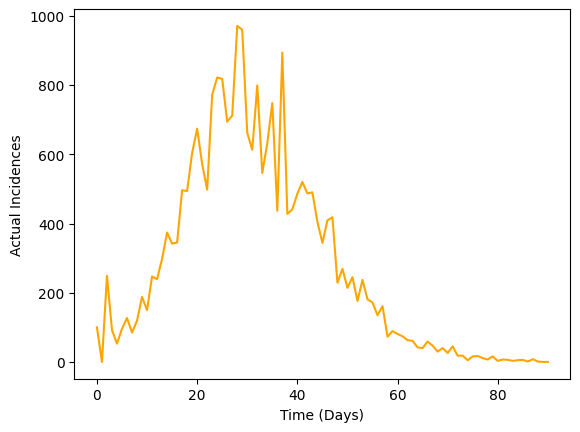

In [45]:
# Generate the incidences of the true infection data
incidences_true = []
for ind, row in time_data.iterrows():
    if ind < len(time_data) - 1:
        incidence = 0
        element_zero = []
        for i in range(1, len(row)):
            if row[i] == 1:
                element_zero.append(i)
        if len(element_zero) > 0:
            for i in element_zero:
                if time_data.iloc[ind + 1, i] > 1 and time_data.iloc[ind + 1, i] < 9:
                    incidence += 1
        incidences_true.append(incidence)
    else:
        break
incidences_true.insert(0, true_result_plot[0])
plt.figure()
plt.plot(incidences_true, color='orange')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Incidences')
plt.show()

#### Model Description

According to above definition, we have defined the following model based on reference (1):
$$\theta_t\sim\text{N}\left(\sum^{\infty}_{\tau=1}\omega_{t-\tau}I_t,\;\sigma\right)$$
Here, the prevalence $\theta_t$ obeys a normal distribution with variance $\sigma$. The mean can be interpreted as the sum of infected people that are positive on time $t$ from previous days. The variance can represent the randomness of the sampling process. Here you can see that the values of $\omega$ is very important. These values of $\omega$ is from the paper in reference (2), on the following repository: . You can also have a look at the shape of $\omega$ values below. $\omega$ values increase at first due to the existence of incubation period. And then decrease due to the immunity. 

However, this data is directly obtained in the repository, a better approach to obtain the $\omega$ values is to implement the procedures in the paper to calculate the values of $\omega$ based on the data generated from `EpiABM`. In addition, this model may not be fully compatible with `EpiABM`. The reason is that `EpiABM` does not have a direct representation of values of $\omega$.

Therefore, future work can be done here: A pipeline to take the testing result of a group of people over a period -> Generate the values of $\omega$ -> Then use these $\omega$ to predict the $R_t$ of a disease.

#### Estimate the Omega

In [48]:
# Select a group of people and keep track to sample them for some time
np.random.seed(10)
small_group_time_sample = [15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]
sampler = epios.Sampler(demo_data)
people = sampler.sample(50)
result_small_group_df = pd.DataFrame({})
for person in people:
    if time_data.loc[small_group_time_sample[0], person] == 9:
        continue
    if time_data.loc[small_group_time_sample[-1], person] != 1 and time_data.loc[small_group_time_sample[-1], person] != 2:
        new_col = list(time_data.loc[small_group_time_sample, person].values)
        result_small_group_df[person] = new_col
result_small_group_df.index = small_group_time_sample
symptom_data_df = pd.DataFrame({'num_id': [], 'date': [], 'symptom': []})
for col_name, data in result_small_group_df.iteritems():
    for ind, data_point in enumerate(data):
        if data_point in [4, 5, 6, 7, 8]:
            symptom = True
        else:
            symptom = False
        symptom_data_df.loc[len(symptom_data_df)] = [col_name, small_group_time_sample[ind], symptom]
symptom_data_df.to_csv('symptom_data.csv', index=False)
test_data_df = pd.DataFrame({'num_id': [], 'date': [], 'pcr_result': [], 'serology_date': [], 'ct': []})
for col_name, data in result_small_group_df.iteritems():
    if set(np.unique(data.values)) <= set([1, 2, 3, 9, 10]):
        continue
    for ind, data_point in enumerate(data):
        if data_point in [3, 4, 5, 6, 7, 8]:
            pcr_result = True
        else:
            pcr_result = False
        test_data_df.loc[len(test_data_df)] = [col_name, small_group_time_sample[ind], pcr_result, 'NA', 'NA']
test_data_df.to_csv('test_data.csv', index=False)

/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/ipykernel_35321/1974233715.py:15: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/ipykernel_35321/1974233715.py:24: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



#### Model Implementation

In `EpiPI`, we will use `PyStan` to generate inference of $I_t$ and $\sigma$. Installation on x86 CPU are simple. However, for Apple Silicon, extra work is still needed. The best option would be a SnakeMake file to install specific versions of `httpstan (4.10.1)` and `pysimdjson (5.0.2)`. `This is necessary to complete in the future.`

The following code is to use `EpiPI` to predict incidences. Firstly, let's try performance of this model by using the actual infection data.

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (

Mean R_hat is 1.0
Std R_hat is 0.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],208.195,16.326,178.589,238.482,0.221,0.156,5635.0,3137.0,1.0
I[1],21.555,17.981,0.007,54.881,0.265,0.213,4760.0,2708.0,1.0
I[2],42.644,25.483,0.168,85.169,0.368,0.260,4046.0,1827.0,1.0
I[3],46.899,30.390,0.114,99.175,0.480,0.347,3511.0,2311.0,1.0
I[4],82.138,39.685,1.664,144.919,0.670,0.474,3256.0,1996.0,1.0
...,...,...,...,...,...,...,...,...,...
I[78],27.479,18.295,0.010,59.045,0.237,0.180,4934.0,2668.0,1.0
I[79],21.265,15.401,0.002,48.923,0.199,0.149,4957.0,2167.0,1.0
I[80],19.730,14.585,0.052,45.496,0.196,0.143,4549.0,2499.0,1.0
I[81],24.122,17.102,0.002,54.465,0.238,0.168,3846.0,2363.0,1.0


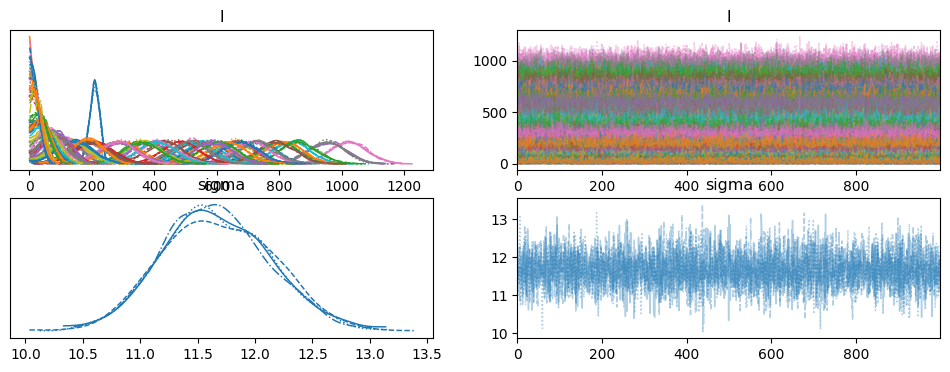

In [54]:
# Predict the R_t value using the actual infection data
theta = theta_true

# theta = theta_true
kernel = [0, 0, 0]
starting_time_point = 0
end_time_point = len(theta)
init_infection = 100
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())
df

Here we can see that the convergence is generally good. All values are within a resonable range. $\hat{R}$ is also pretty low and stable for all parameters, which all equals to 1.0. Then let's see the comparison between the actual incidences and the estimated ones.

Remarks:

1. At the end of the inference period, since the number of $\theta$ can be used to generate inference of $I$ is fewer and fewer, the values of last few $I$s will roughly be the its initial values at the start of the iteration. To overcome this issue, I have defined `kernel` to let users to input the values of the last few $I$s. If there is no information that the user can provide, it can be left as blank. The user can discard the last few inferences manually. After experiments, these last values will not affect $I$ values predicted at smaller time points.

In [55]:
# Plot the predicted incidences
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + kernel)

figure = go.Figure()

trace1 = go.Scatter(
    y=pre_I,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Estimated Incidences',
    line_color='indigo'
)

trace2 = go.Scatter(
    x=list(range(starting_time_point, end_time_point)) + list(range(starting_time_point, end_time_point))[::-1],
    y=(pre_I + 1.96 * pre_std).tolist() + (pre_I - 1.96 * pre_std).tolist()[::-1],
    fill='toself',
    fillcolor='indigo',
    line_color='indigo',
    opacity=0.5,
    mode='lines',
    name='Credible interval 0.95',
)

trace3 = go.Scatter(
    y=incidences_true,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual Incidences',
    line_color='green'
)

figure.add_trace(trace1)
figure.add_trace(trace2)
figure.add_trace(trace3)
figure.update_layout(xaxis_title='Time (Day)', yaxis_title='Incidence Number')

Generally, we can see that the result performs very well. Therefore, we try to use the interpolated total infection below.

In [1]:
# Predict the R_t value using the interpolated infection data
theta = theta_inter

# theta = theta_true
kernel = [0, 0, 0]
starting_time_point = 0
end_time_point = len(theta)
init_infection = 100
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())
df

NameError: name 'theta_inter' is not defined

In [51]:
# Plot the predicted incidences
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + kernel)

figure = go.Figure()

trace1 = go.Scatter(
    y=pre_I,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Estimated Incidences',
    line_color='indigo'
)

trace2 = go.Scatter(
    x=list(range(starting_time_point, end_time_point)) + list(range(starting_time_point, end_time_point))[::-1],
    y=(pre_I + 1.96 * pre_std).tolist() + (pre_I - 1.96 * pre_std).tolist()[::-1],
    fill='toself',
    fillcolor='indigo',
    line_color='indigo',
    opacity=0.5,
    mode='lines',
    name='Credible interval 0.95',
)

trace3 = go.Scatter(
    y=incidences_true,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual Incidences',
    line_color='green'
)

figure.add_trace(trace1)
figure.add_trace(trace2)
figure.add_trace(trace3)
figure.update_layout(xaxis_title='Time (Days)', yaxis_title='Incidence Number')

Generally, the interpolated data does not work much worse than the true infection data. The performance might be improved if the interpolation methods are more accurate.

## Limited Resources

In [16]:
total_sample_prop = 0.2
iterations = 20
list_sample_interval = [7, 14, 30]
MCMC_iterations = 500

In [17]:
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 3.96
ws_var = 4.75**2
theta_num = ws_var / ws_mean
k = ws_mean / theta_num
w_dist = scipy.stats.gamma(k, scale=theta_num)

In [20]:
res_total = []
for sample_interval in list_sample_interval:
    res_ite = []
    for _ in range(iterations):
        total_sample_size = int(total_sample_prop * len(demo_data))
        time_sample = list(range(sample_interval, len(time_data), sample_interval))
        sample_size = int(total_sample_size / len(time_sample))
        true_rt_ite = true_rt[tau + 1:max(time_sample) + 1]

        # Do prediction and comparison based age-region stratification
        result, diff = postprocess.predict.Base(sample_size=sample_size,
                                                time_sample=time_sample,
                                                comparison=False,
                                                #  non_responder=False,
                                                gen_plot=False,
                                                sample_strategy='Random')

        # Gaussian Process Interpolation
        # Trusted data points
        sampled_result = result[1]
        if any([item == 0 for item in sampled_result]):
            print('Zero value detected in the sampled result, skip this iteration')
            continue
        sampled_result.insert(0, 100 / len(demo_data))
        time_sample_interpolating = [0] + time_sample
        X = np.array(time_sample_interpolating).reshape(-1, 1)  # Time points
        y = np.array(sampled_result) * len(demo_data)  # Values
        y = np.log(y)  # Logarithm of the values

        # Define Gaussian Process
        kernel = ConstantKernel(1, (1e-2, 1e2)) * RBF(1, (1e-6, 1e6)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-3, 1e-2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

        # Fit to data using Maximum Likelihood Estimation of the parameters
        gp.fit(X, y)

        # Make the prediction on the meshed x-axis (ask for MSE as well)
        X_all = np.arange(max(time_sample) + 1).reshape(-1, 1)
        y_pred = gp.predict(X_all, return_std=False)
        theta = np.exp(y_pred)  # Exponential of the prediction

        kernel = [0, 0, 0]
        controller = epipi.InferenceController(theta, omega, kernel=kernel, num_samples=MCMC_iterations, num_warmup=500)
        fit, samples = controller.run()
        df = az.summary(samples)
        print('Max R_hat is', df['r_hat'].values.max())
        pre_I = np.array(list(df['mean'].values[:-1]) + kernel)

        # Use incidence data to predict R_t value
        disc_w = w_dist.pdf(range(len(theta)))
        serial_interval = disc_w
        serial_interval = serial_interval[1:]
        # Plot comparison between the true and predicted R_t
        # Transform our incidence data into pandas dataframes
        inc_data = pd.DataFrame(
            {
                'Time': np.arange(len(theta)),
                'Incidence Number': pre_I
            }
        )

        inference = branchpro.BranchProPosterior(
            inc_data=inc_data,
            daily_serial_interval=serial_interval,
            alpha=a,
            beta=1/b)

        inference.run_inference(tau=tau)
        intervals = inference.get_intervals(central_prob=.95)

        pred_rt = intervals['Mean'].values
        rmse = np.sqrt(np.mean((true_rt_ite - pred_rt) ** 2))
        res_ite.append(rmse)
    res_total.append(res_ite)

Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   3% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   3% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   3%

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   3% (101/4000)
Sampling:   3

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.02
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  30% (1200/4000)
Sampling:  32% (

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:   5% (202/4000)
Sampling:   8% (301/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  15% (600/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  45% (

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
W

Max R_hat is 1.0
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% (3/4000)
Sampling:   0% (4/4000)
Sampling:   3% (103/4000)
Sampling:  28% (1102/4000)
Sampling:  53% (2101/4000)
Sampling:  78% (3100/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.0
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 0.01. Increasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0% 

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01
Building...


/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   0%

Max R_hat is 1.01


Mean RMSE - 7 days 0.49100519160980455
Std RMSE - 7 days 0.06883880495649032


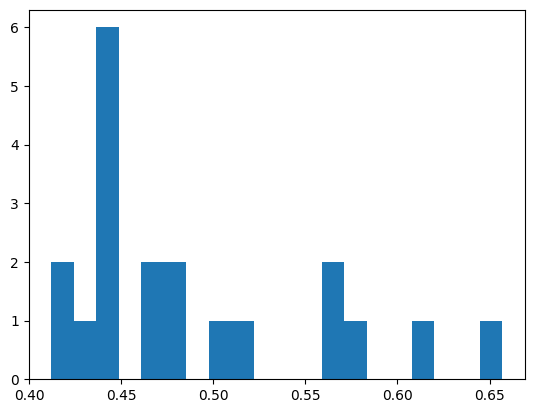

In [23]:
print('Mean RMSE - 7 days', np.mean(res_total[0]))
print('Std RMSE - 7 days', np.std(res_total[0]))
plt.figure()
plt.hist(res_total[0], bins=20)
plt.show()

Mean RMSE - 14 days 0.43255775979729166
Std RMSE - 14 days 0.006797378292873753


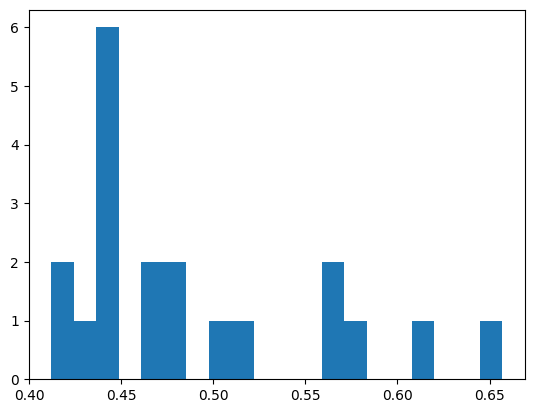

In [24]:
print('Mean RMSE - 14 days', np.mean(res_total[1]))
print('Std RMSE - 14 days', np.std(res_total[1]))
plt.figure()
plt.hist(res_total[0], bins=20)
plt.show()

### References

1. Bajaj, Sumali, et al. "Understanding COVID-19 testing behaviour in England through a sociodemographic lens." medRxiv (2023): 2023-10.
2. Hellewell, Joel, et al. "Estimating the effectiveness of routine asymptomatic PCR testing at different frequencies for the detection of SARS-CoV-2 infections." BMC medicine 19 (2021): 1-10.

# Future Work:

1. All future works mentioned above
3. Develop pipeline to predict the $R_t$, we can do this by sampling a small sample